In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns

In [16]:
df = pd.read_csv("/home/bethtian/fintech545/FinTech545_Spring2025/Projects/Project01/problem4.csv")
df.describe()

,y
count,1000.000000
mean,4.997666
std,0.135114
min,4.598763
25%,4.902053
50%,4.996434
75%,5.095853
max,5.413747


#  A. Simulate an MA(1), MA(2), and MA(3) process and graph the ACF and PACF of each. What do you notice?

In [17]:
def generate_ma(order, n_samples=1000):

    np.random.seed(42)
    e = np.random.normal(0, 1, n_samples + order)
    
    if order == 1:
        params = [0.7] 
    elif order == 2:
        params = [0.7, 0.4]  
    else: 
        params = [0.7, 0.4, 0.2]  
    
    y = np.zeros(n_samples)
    for t in range(n_samples):
        y[t] = e[t + order]
        for i in range(order):
            y[t] += params[i] * e[t + order - i - 1]
    
    return y, params


In [18]:
def plot_acf_pacf(data, title, lags=40):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # ACF
    acf_values = acf(data, nlags=lags)
    ax1.stem(range(len(acf_values)), acf_values)
    ax1.axhline(y=0, linestyle='-', color='gray')
    ax1.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    ax1.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    ax1.set_title(f'ACF - {title}')
    
    # PACF
    pacf_values = pacf(data, nlags=lags)
    ax2.stem(range(len(pacf_values)), pacf_values)
    ax2.axhline(y=0, linestyle='-', color='gray')
    ax2.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    ax2.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    ax2.set_title(f'PACF - {title}')
    
    plt.tight_layout()
    plt.show()

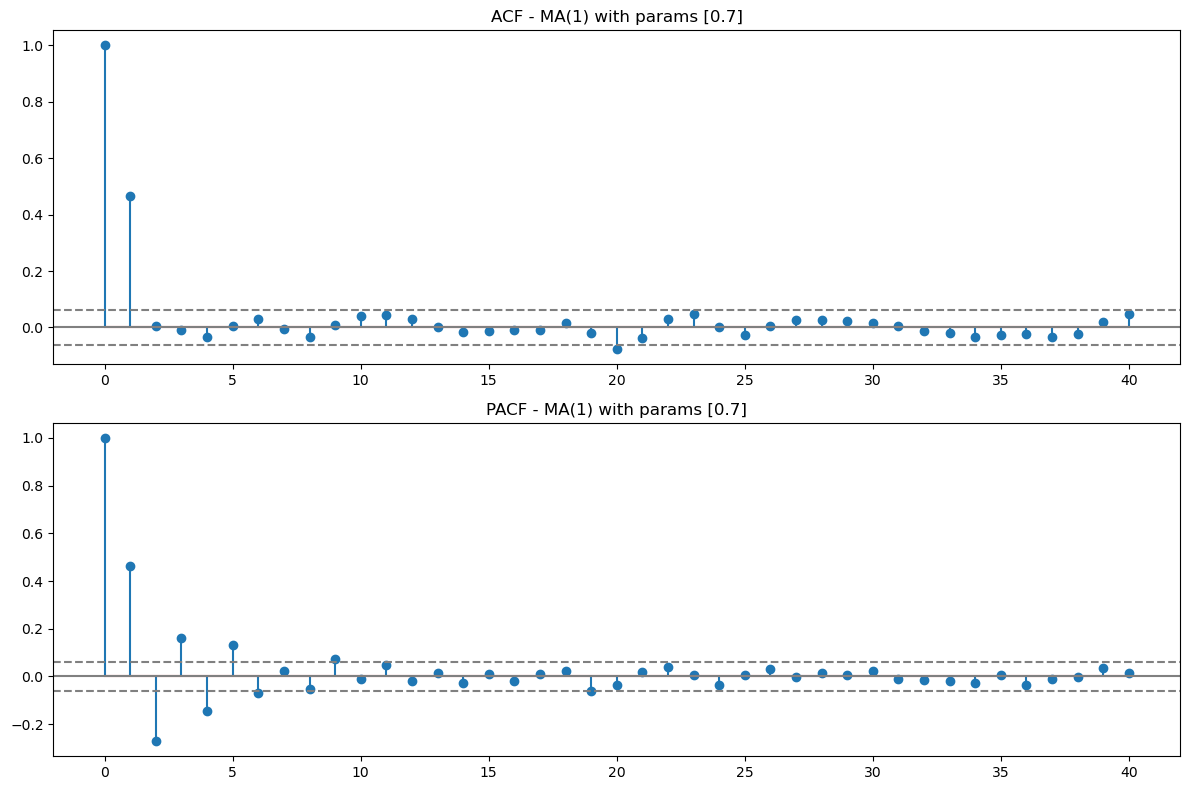

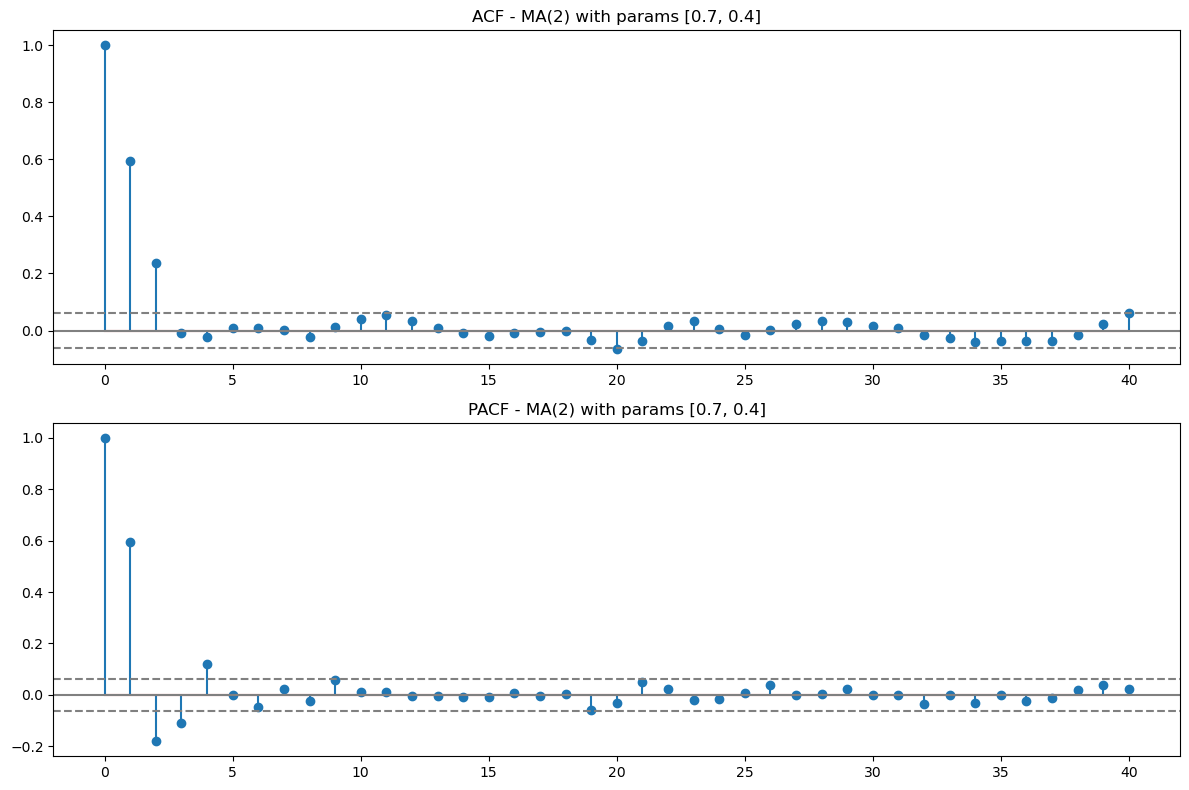

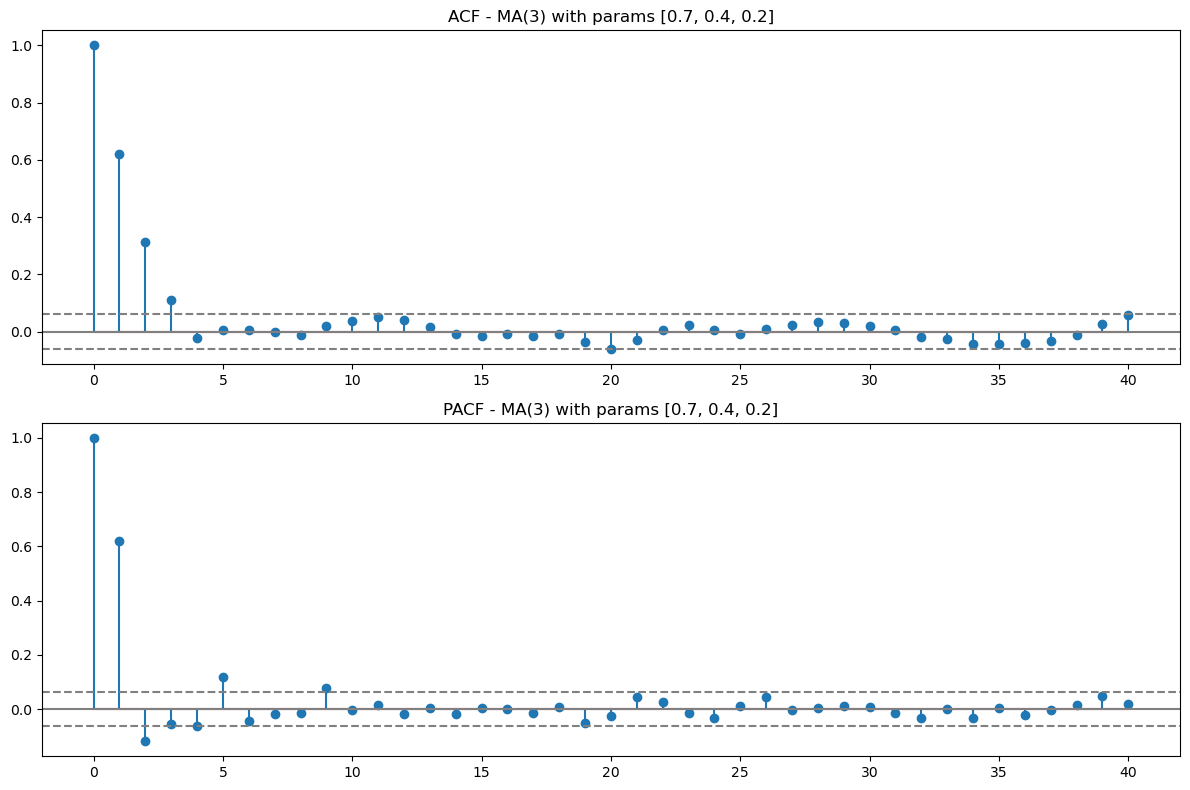

In [19]:
for order in [1, 2, 3]:
    ma_data, ma_params = generate_ma(order)
    plot_acf_pacf(ma_data, f'MA({order}) with params {ma_params}')

#  B. Simulate an AR(1), AR(2), and AR(3) process and graph the ACF and PACF of each. What do you notice?

In [20]:
def generate_ar(order, n_samples=1000):
    np.random.seed(42)
    y = np.zeros(n_samples)
    e = np.random.normal(0, 1, n_samples)
    
    if order == 1:
        params = [0.7]
    elif order == 2:
        params = [0.7, 0.4] 
    else:  
        params = [0.7, 0.4, 0.2] 
    
    for t in range(order, n_samples):
        y[t] = sum(params[i] * y[t-i-1] for i in range(order)) + e[t]
    
    return y, params

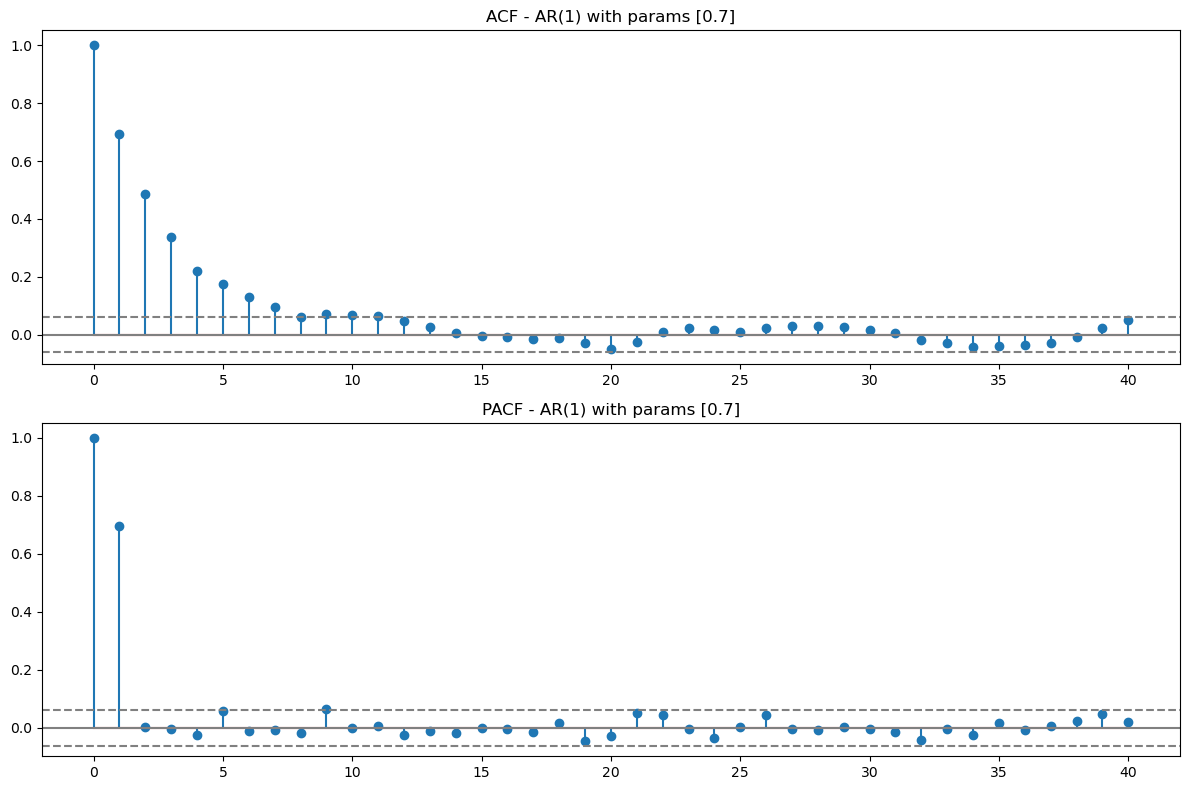

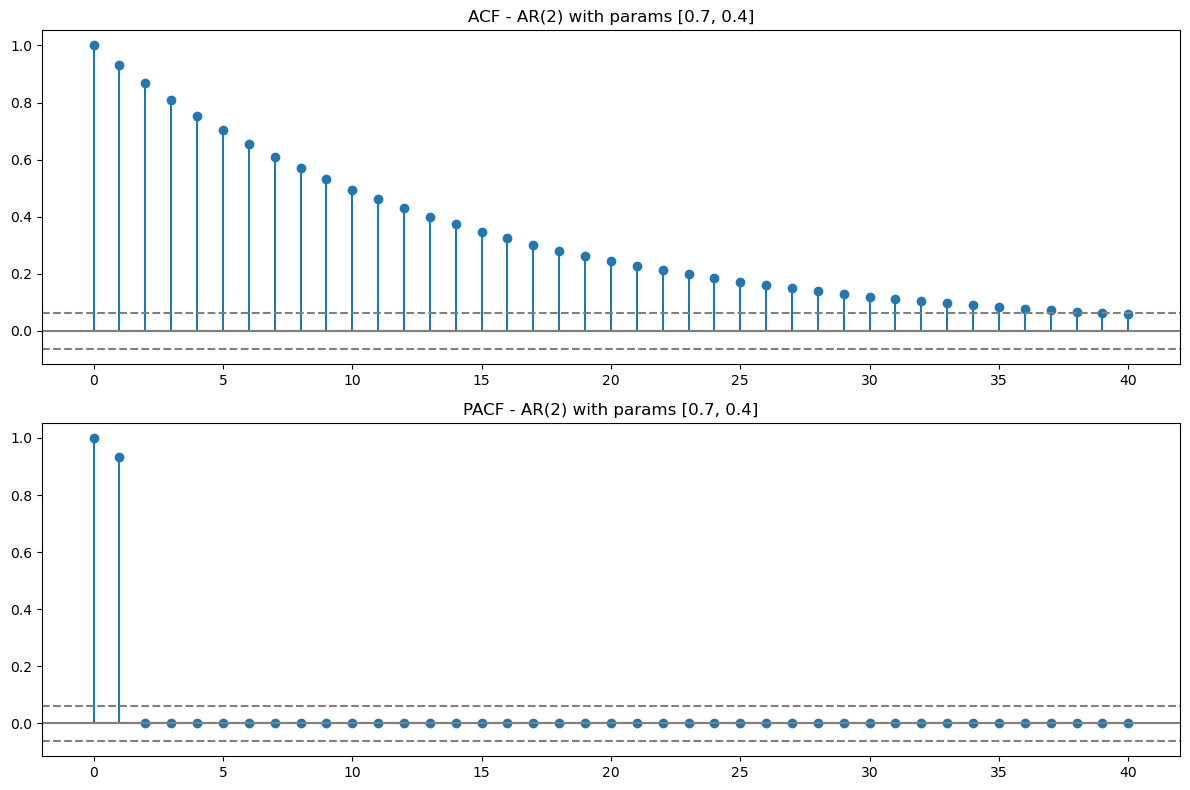

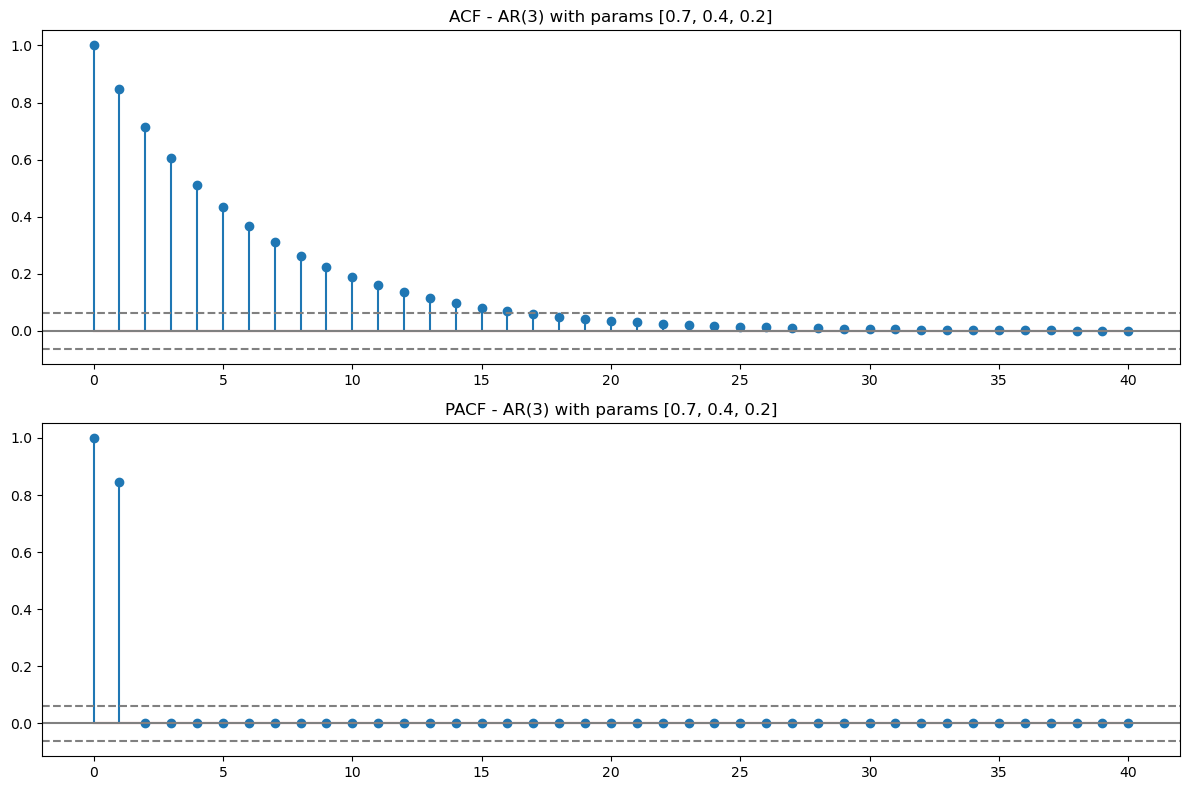

In [21]:
for order in [1, 2, 3]:
    ar_data, ar_params = generate_ar(order)
    plot_acf_pacf(ar_data, f'AR({order}) with params {ar_params}')

# C. Examine the data in problem4.csv. What AR/MA process would you use to model the data? Why?

In [22]:
def compare_models(data, max_order=3):
    results = {}

    for order in range(1, max_order + 1):
        #AR
        ar_model = ARIMA(data, order=(order,0,0))
        ar_results = ar_model.fit()
        results[f'AR({order})'] = {
            'aicc': ar_results.aicc,
            'params': ar_results.arparams,
            'model': ar_results
        }
        
        #MA
        ma_model = ARIMA(data, order=(0,0,order))
        ma_results = ma_model.fit()
        results[f'MA({order})'] = {
            'aicc': ma_results.aicc,
            'params': ma_results.maparams,
            'model': ma_results
        }
    print("\nModel result comparison(ranked by AIC):")
    for model, info in sorted(results.items(), key=lambda x: x[1]['aicc']):
        print(f"{model}:")
        print(f"  AICc: {info['aicc']:.2f}")
        print(f"  Parameters: {info['params']}")
        print()
    
    return results

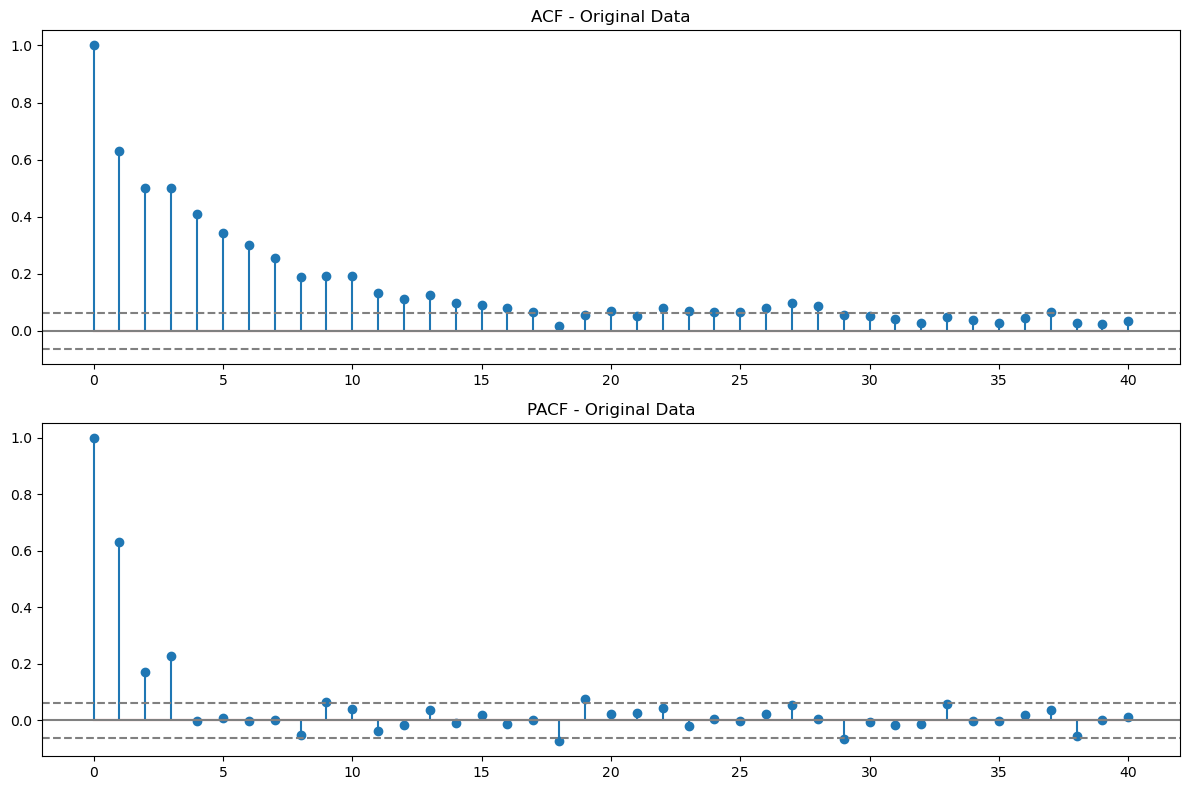

In [23]:
plot_acf_pacf(df, 'Original Data')

According to the pictures of ACF and PACF, the ACF of the data is tailing off, similar to the ACF of simulation AR process. Hence, I will use the AR model.

Because the PACF of the data shows significant spikes up to lag 4, I would like to use the AR(4) model.


# D. Fit the model of your choice in C along with other AR/MA models. Compare the AICc of each. What is the best fit?

In [24]:
def compare_models(data):
    results = {}
    
    # AR
    for p in range(1, 7):  
        model = ARIMA(data, order=(p, 0, 0))
        results[f'AR({p})'] = model.fit()
    
    # MA
    for q in range(1, 6):  
        model = ARIMA(data, order=(0, 0, q))
        results[f'MA({q})'] = model.fit()
    
    for name, model in results.items():
        print(f"{name}: AICc = {model.aicc:.2f}")
        
    best_model = min(results.items(), key=lambda x: x[1].aicc)
    print(f"\nOptimal model: {best_model[0]}")
    return results

In [25]:
result = compare_models(df)

AR(1): AICc = -1669.07
AR(2): AICc = -1696.05
AR(3): AICc = -1746.22
AR(4): AICc = -1744.22
AR(5): AICc = -1742.25
AR(6): AICc = -1740.23
MA(1): AICc = -1508.90
MA(2): AICc = -1559.21
MA(3): AICc = -1645.07
MA(4): AICc = -1677.50
MA(5): AICc = -1703.14

Optimal model: AR(3)


Because the spikes are not significant since 5, I tried to fit the AR model from AR(1) to AR(6). I also fitted the MA model from MA(1) to MA(5). The AICc results shows that the AR(3) model fits the data best, with the lowest AICc.

The fitting result is a little bit different from my prediction. I guess the reason may be that the forth parameter does not provide sufficient explanatory power, but increases the increased model complexity. Hence, the AICc gives more punishment to the complexity than the increment to the contribution.